#### SUMMARY of using only FSL all the way through:

From a weeks work of trial and error (40h) it was discovered that this was the best preprocessing steps using FSL on 3d .nii(.gz) brain images 

- Step 1: Extract images from subfolders into one/more folders for easier loading (eg `176`, `208` with `sub-ADNI002S0413_ses-M132_T1w.nii.gz` images)
- Step 2: Skull stripping (neck stripping) using bet -f=0.3, -g = 0.8
- Step 3: Bias field correction. (fast -B) (we will do this together with )
- Step 4: Skull stripping (top of head stripping) using bet -f=-0.1, -g=0.2, -R
- Step 5: Spatial normalization using flirt.

Prerequisites:

- Installing fsinstaller (from the first article Alcoholism Detection by Data Augmentation and Convolutional Neural Network with Stochastic Pooling:)
1. https://fsl.fmrib.ox.ac.uk/fsl/docs/#/
2. ubuntu> python3 "/mnt/c/Users/kiran/Downloads/fslinstaller.py"

In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import nibabel as nib

# from keras.utils import to_categorical
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
def load_n1_to_n2_nifti_images(root_dir, n1, n2, endswith='.nii.gz'):
    # Function to load NIfTI files from the given root directory in the range n1 to n2
    images = []
    image_count = 0
    
    # Traverse the directory structure
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(endswith):
                # Build full file path
                file_path = os.path.join(root, file)
                print(f"Loading: {file_path}")
                
                # Load NIfTI image
                img = nib.load(file_path)
                img_data = img.get_fdata()
                
                # Add the image to the list if it's within the specified range
                if n1 <= image_count < n2:
                    images.append(img_data)
                
                image_count += 1
                
                # Stop if we've loaded n2 images
                if image_count >= n2:
                    return images
    
    return images

root_directory = r"C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\bids_sick_raw"

images = load_n1_to_n2_nifti_images(root_directory, 0, 500, endswith='.nii') # Load images from n1 to n2

# Convert the list of images to a NumPy array (optional, depending on how you want to process them)
#images_array = np.array(images)
for i, image in enumerate(images):
    print(i, len(image), image.shape)

# Print the shape of the loaded images (this is just an example, adjust based on your needs)
#print(f"Loaded {len(images)} images with shape: {images_array.shape}")

# Now images_array contains the first 10 loaded NIfTI image data from the sessions and subjects.

Loading: C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\bids_sick_raw\AD ADNI1_Annual 2 Yr 3T\ADNI\002_S_1018\MPR____N3__Scaled\2006-12-18_14_57_09.0\I40828\ADNI_002_S_1018_MR_MPR____N3__Scaled_Br_20070217032215330_S24312_I40828.nii
Loading: C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\bids_sick_raw\AD ADNI1_Annual 2 Yr 3T\ADNI\002_S_1018\MPR____N3__Scaled\2007-12-07_18_28_23.0\I97022\ADNI_002_S_1018_MR_MPR____N3__Scaled_Br_20080313095739932_S43496_I97022.nii
Loading: C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\bids_sick_raw\AD ADNI1_Annual 2 Yr 3T\ADNI\002_S_1018\MPR____N3__Scaled\2008-12-12_09_06_11.0\I132795\ADNI_002_S_1018_MR_MPR____N3__Scaled_Br_20090106140133108_S60846_I132795.nii
Loading: C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\bids_sick_raw\AD ADNI1_Annual 2 Yr 3T\ADNI\005_S_0814\MPR__GradWarp__B1_Correction__N3__Scaled\2006-09-20_11_11_42.0\I74600\ADNI_005_S_0814_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070923123736255_S19117_I74600.nii
Loading: C:\Users\kiran\Docu

### STEP 1

We observe 3 shapes, we may have to process them seperately (for the spatial normalization for example)

- (256, 256, 170)
- (256, 256, 166)
- (240, 256, 160)

Therefore 3 subfolders will be made under the folder `bids_sick_extracted`

In [ ]:
def load_and_save_nifti_images(root_dir, output_dir, n1=0, n2=10_000, endswith='.nii.gz'):
    
    # Traverse the directory structure
    image_count = 0
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(endswith):

                # Build full file path
                file_path = os.path.join(root, file)
                print(f"Loading: {file_path}")
                
                # Load NIfTI image
                img = nib.load(file_path)
                img_data = img.get_fdata()
                
                # Process the image if it's within the specified range
                if n1 <= image_count < n2:
                    formatted_shape = "_".join(map(str, img_data.shape))  # "240_256_160" because .bash files struggle with spaces and paranthesis
                    output_path_folder = os.path.join(output_dir, formatted_shape)

                    if not os.path.exists(output_path_folder):
                        os.makedirs(output_path_folder, exist_ok=True)

                    # Save the image to the appropriate folder
                    output_path_file = os.path.join(output_path_folder, f"{image_count}_{file}")
                    nib.save(img, output_path_file)
                    print(f"Saved: {output_path_file}")
                
                image_count += 1
                
                # Stop if we've processed up to n2 images
                if image_count >= n2:
                    return
    
    print(f"Extraction completed. Processed {image_count - n1} images in total.")

# Load and save images from n1 to n2
load_and_save_nifti_images(
    #root_dir=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\bids_sick_raw\AD ADNI1_Annual 2 Yr 3T",
    #output_dir=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\bids_sick_extracted\AD", 
    root_dir=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\bids_sick_raw\MCI ADNI1_Annual 2 Yr 3T",
    output_dir=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\bids_sick_extracted\MCI", 
    n1=0, n2=3000, endswith='.nii')

Loading: C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\bids_sick_raw\MCI ADNI1_Annual 2 Yr 3T\ADNI\002_S_0729\MPR____N3__Scaled\2006-08-02_07_02_00.0\I40692\ADNI_002_S_0729_MR_MPR____N3__Scaled_Br_20070217001301848_S17535_I40692.nii
Saved: C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\bids_sick_extracted\MCI\256_256_170\0_ADNI_002_S_0729_MR_MPR____N3__Scaled_Br_20070217001301848_S17535_I40692.nii
Loading: C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\bids_sick_raw\MCI ADNI1_Annual 2 Yr 3T\ADNI\002_S_0729\MPR____N3__Scaled\2007-09-05_07_54_56.0\I78663\ADNI_002_S_0729_MR_MPR____N3__Scaled_Br_20071027115015319_S38913_I78663.nii
Saved: C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\bids_sick_extracted\MCI\256_256_170\1_ADNI_002_S_0729_MR_MPR____N3__Scaled_Br_20071027115015319_S38913_I78663.nii
Loading: C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\bids_sick_raw\MCI ADNI1_Annual 2 Yr 3T\ADNI\002_S_0729\MPR____N3__Scaled\2008-09-29_11_52_49.0\I124008\ADNI_002_S_0729_MR_MPR____N3__Scaled_Br_2008102

Image shape: (240, 256, 160)


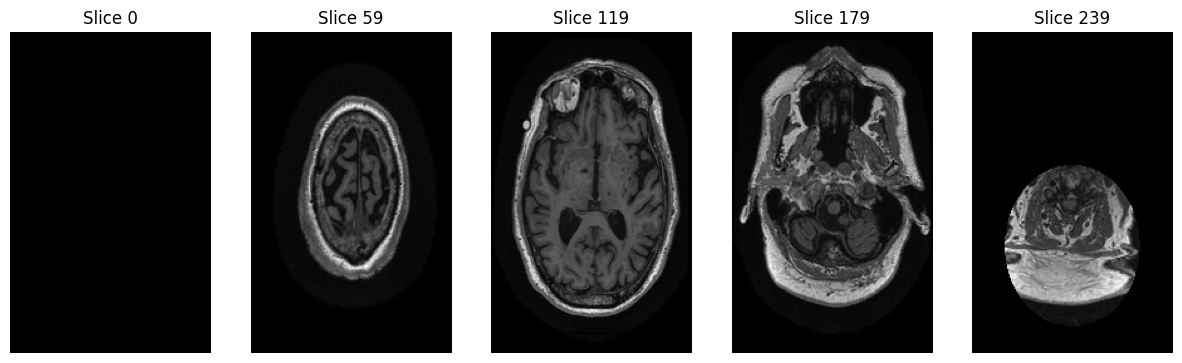

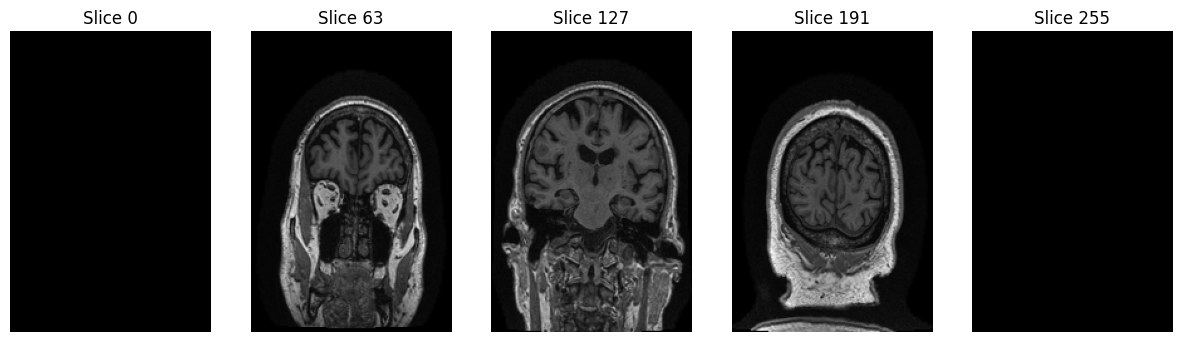

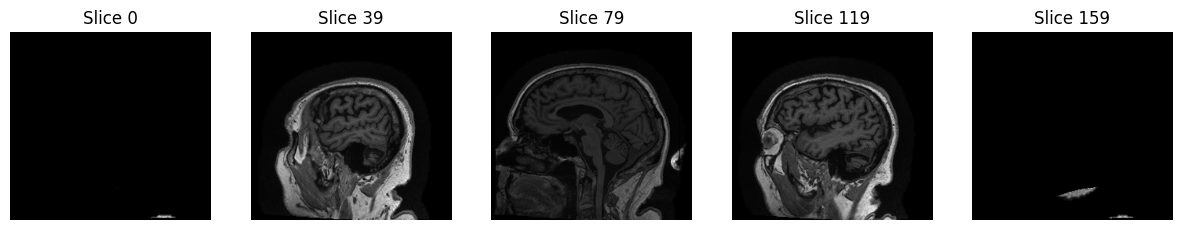

In [69]:
# Plot slices from different axes
def plot_slices(data, count=5, axis=0, transpose=False):
    """Plot slices along a specified axis."""
    slices = data.shape[axis]
    fig, axes = plt.subplots(1, count, figsize=(15, 5))
    slice_indices = np.linspace(0, slices - 1, count, dtype=int)  # Choose 5 slices
    
    for i, idx in enumerate(slice_indices):
        if axis == 0:
            slice_data = data[idx, :, :]
        elif axis == 1:
            slice_data = data[:, idx, :]
        else:
            slice_data = data[:, :, idx]
        
        if transpose:
            axes[i].imshow(slice_data.T, cmap="gray", origin="lower")  # Transpose for correct orientation
        else:
            axes[i].imshow(slice_data, cmap="gray")  # Transpose for correct orientation
        axes[i].set_title(f"Slice {idx}")
        axes[i].axis("off")
    
    plt.show()

# Plot slices along each axis
file_path = r"C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\bids_sick_extracted\AD\240_256_160\8_ADNI_023_S_0916_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20061203143925761_S19523_I31540.nii"
img = nib.load(file_path) # Load the NIfTI file
img_data = img.get_fdata() # Get the image data as a NumPy array

print(f"Image shape: {img_data.shape}") # Print shape to understand the dimensions
plot_slices(img_data, count=5, axis=0)  # Axial slices
plot_slices(img_data, count=5, axis=1)  # Coronal slices
plot_slices(img_data, count=5, axis=2)  # Sagittal slices

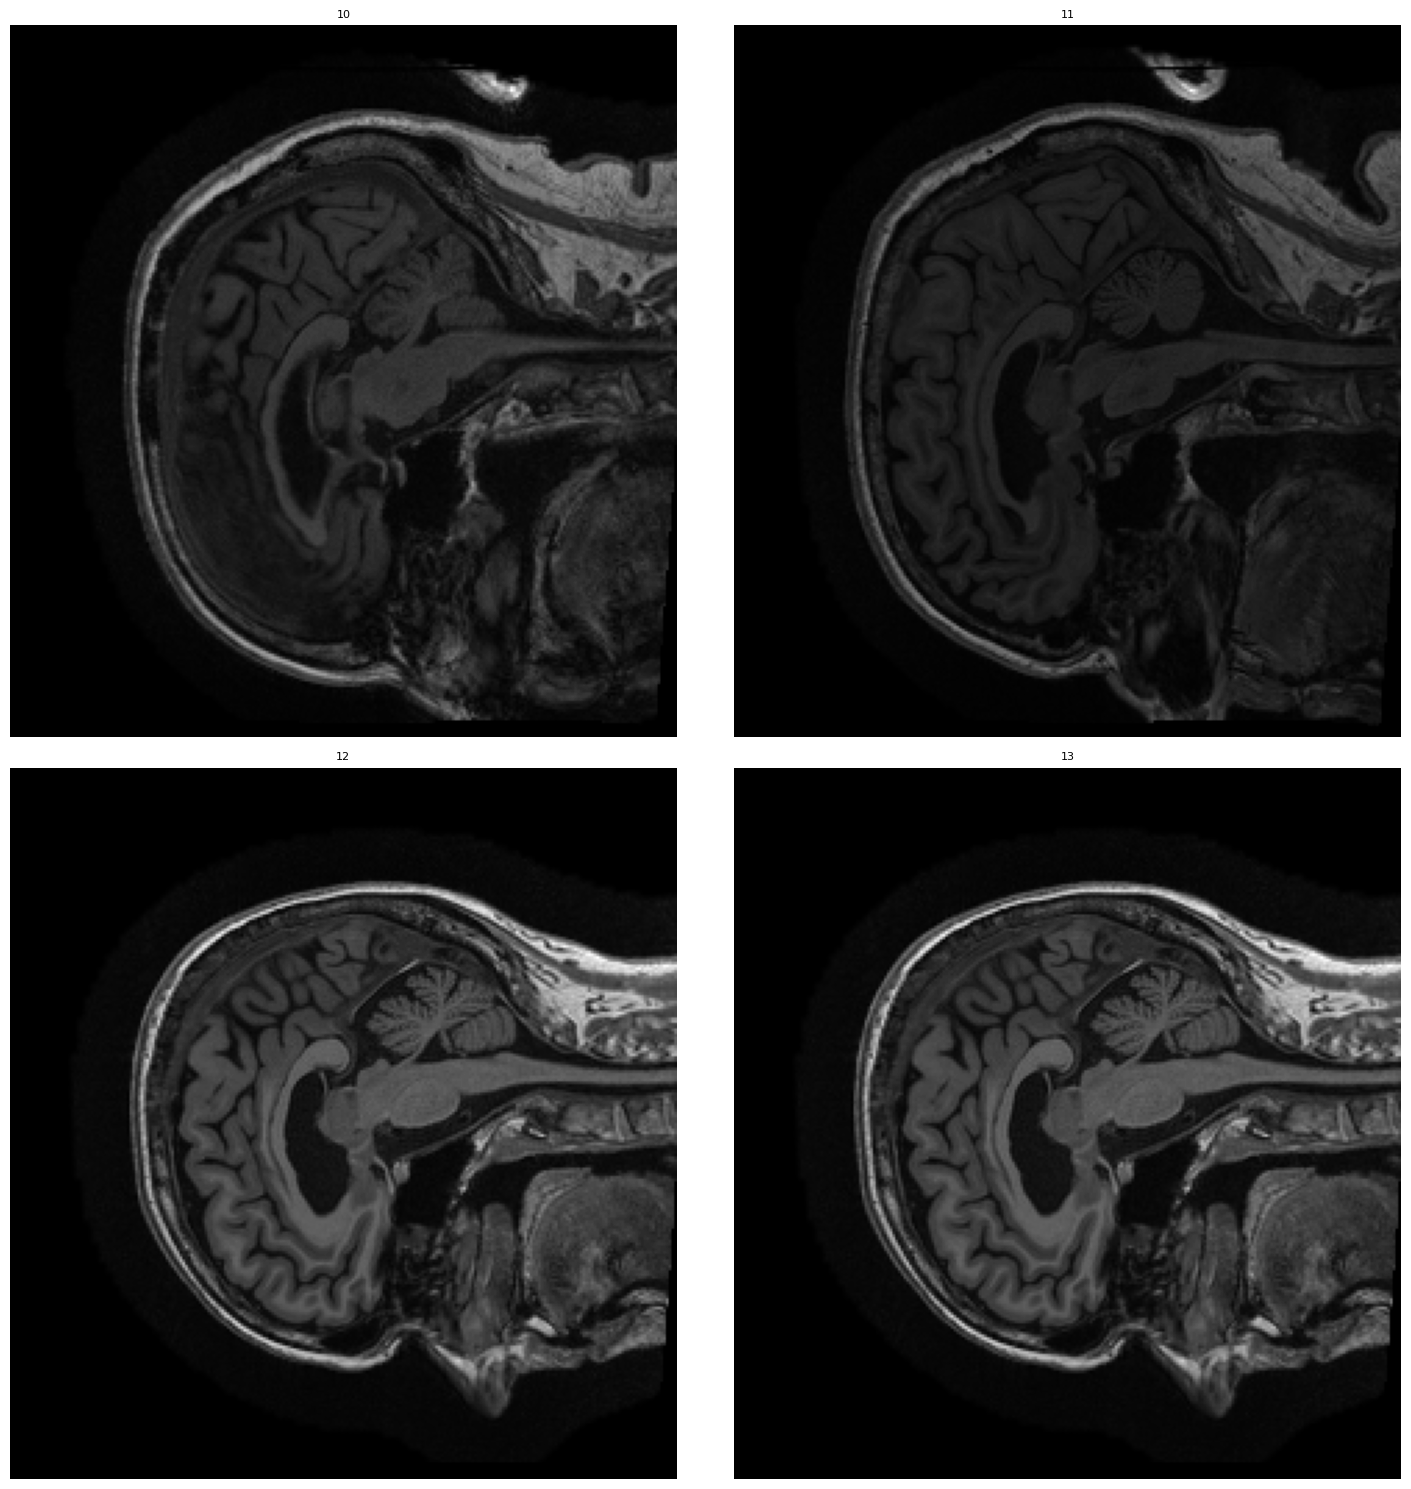

In [ ]:

def plot_middle_slices_in_range_old(folder_path, n1, n2, axis=1, endwith='.nii'):
    "Function to plot the middle slices of images between n1 and n2 in a single figure"
    # Get a sorted list of all files in the directory excluding mask files
    all_files = sorted(
        [f for f in os.listdir(folder_path) if f.endswith(endwith) and not f.endswith('_mask'+endwith)]
    )
    
    # Filter files between n1 and n2
    selected_files = all_files[n1:n2]
    num_images = len(selected_files)
    
    # Determine grid size for the plot
    cols = math.ceil(math.sqrt(num_images))  # Number of columns in the grid
    rows = math.ceil(num_images / cols)  # Number of rows in the grid
    
    # Create a figure for plotting
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()  # Flatten to easily iterate over axes
    
    for i, file in enumerate(selected_files):
        file_path = os.path.join(folder_path, file)
        
        # Load the NIfTI file
        img = nib.load(file_path)
        img_data = img.get_fdata()
        
        # Calculate the middle index along axis 0
        middle_index = img_data.shape[axis] // 2
        
        # Plot the middle slice on the current axis
        axes[i].imshow(img_data[middle_index, :, :], cmap='gray')
        axes[i].set_title(file_path.split("\\")[-1].split("_")[0], fontsize=8)
        axes[i].axis('off')
    
    # Hide unused axes if the grid is larger than the number of images
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_middle_slices_in_range(folder_path, n1, n2, axis=1, endwith='.nii'):
    "Function to plot the middle slices of images between n1 and n2 in a single figure"
    # Get a sorted list of all files in the directory excluding mask files
    all_files = sorted(
        [f for f in os.listdir(folder_path) if f.endswith(endwith) and not f.endswith('_mask'+endwith)]
    )
    
    # Filter files between n1 and n2
    selected_files = all_files[n1:n2]
    num_images = len(selected_files)
    
    # Determine grid size for the plot
    cols = math.ceil(math.sqrt(num_images))  # Number of columns in the grid
    rows = math.ceil(num_images / cols)  # Number of rows in the grid
    
    # Create a figure for plotting
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()  # Flatten to easily iterate over axes
    
    for i, file in enumerate(selected_files):
        file_path = os.path.join(folder_path, file)
        
        # Load the NIfTI file
        img = nib.load(file_path)
        img_data = img.get_fdata()
        
        # Calculate the middle index along axis 0
        middle_index = img_data.shape[axis] // 2
        
        # Plot the middle slice on the current axis
        axes[i].imshow(img_data[:, :, middle_index].T, cmap='gray', origin="lower")
        axes[i].set_title(file_path.split("\\")[-1].split("_")[0], fontsize=8)
        axes[i].axis('off')
    
    # Hide unused axes if the grid is larger than the number of images
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()


plot_middle_slices_in_range(
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\bids_sick_extracted\AD\240_256_160"
    , 0, 4, axis=2, endwith=".nii.gz")

### STEP 2. Skull (neck) stripping

But first we apparantly need to compress .nii images to zip files (.gz)

In [ ]:
#!/bin/bash or paste into the ubuntu console
# This will compress all .nii files in the directory and subdirectories

#INPUT_DIR="/mnt/c/Users/kiran/Documents/_UIS/sem6/BACH/Data/bids_sick_extracted/AC"
INPUT_DIR="/mnt/c/Users/kiran/Documents/_UIS/sem6/BACH/Data/bids_sick_extracted/MCI"

# Find all .nii files and compress them into .nii.gz
find "$INPUT_DIR" -type f -name "*.nii" -exec gzip {} \;

echo "All .nii files compressed to .nii.gz."

In [73]:
# checking if the data is truly there?
# ls -l "/mnt/c/Users/kiran/Documents/_UIS/sem6/BACH/Data/bids_sick_extracted/AD/240_256_160/8_ADNI_023_S_0916_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20061203143925761_S19523_I31540.nii.gz"

In [ ]:
#!/bin/bash or paste into the ubuntu console

# Set directories
INPUT_DIR="/mnt/c/Users/kiran/Documents/_UIS/sem6/BACH/Data/bids_sick_extracted/MCI/256_256_170"
# OUTPUT_DIR="/mnt/c/Users/kiran/Documents/_UIS/sem6/BACH/Data/bids_sick_extracted/step2/AD/256_256_166"

# Create output directory if it doesn't exist
#mkdir -p "$OUTPUT_DIR"

# Function to process a single file
process_file() {
    FILE="$1"
    BASENAME=$(basename "$FILE" .nii.gz)
    echo "Processing: $BASENAME"
    
    
    G_PARAM=-0.8
    F_PARAM=0.3
    
    # ls -l FILE
    echo "$FILE"

    # DUE TO SOME WEIRD AF UNEXPECTED ERROR, WE HAVE TO PUT THIS INSIDE THE FUNCTION?? GLOBAL VARIABLE, NO?
    OUTPUT_DIR="/mnt/c/Users/kiran/Documents/_UIS/sem6/BACH/Data/bids_sick_extracted/step3/MCI/256_256_170"
    #echo "$OUTPUT_DIR"
    # echo "$OUTPUT_DIR/${BASENAME%.nii.gz}_brain"

    # Skull stripping using BET with dynamic -f value
    bet "$FILE" "$OUTPUT_DIR/${BASENAME%.nii.gz}_brain" -f "$F_PARAM" -g "$G_PARAM"

    #2. Bias field correction using FAST (not necessary for all images, check image name "B_corrected")
    fast -B "$OUTPUT_DIR/${BASENAME}_brain.nii.gz"
    
    echo "Finished processing: $BASENAME"
}

export -f process_file  # Export the function for parallel execution

# Run in parallel for all .nii.gz files in the input directory
echo "Starting parallel processing..."
# find "$INPUT_DIR" -maxdepth 1 -type f -name "*.nii.gz" -print0 | parallel --jobs "$(nproc)" -0 process_file
# find "$INPUT_DIR" -maxdepth 1 -type f -name "*.nii.gz" | head -n 16 | parallel --jobs "$(nproc)" process_file {}

find "$INPUT_DIR" -maxdepth 1 -type f -name "*.nii.gz" | parallel --jobs "$(nproc)" process_file {}

echo "All images processed. Results are in: $OUTPUT_DIR"


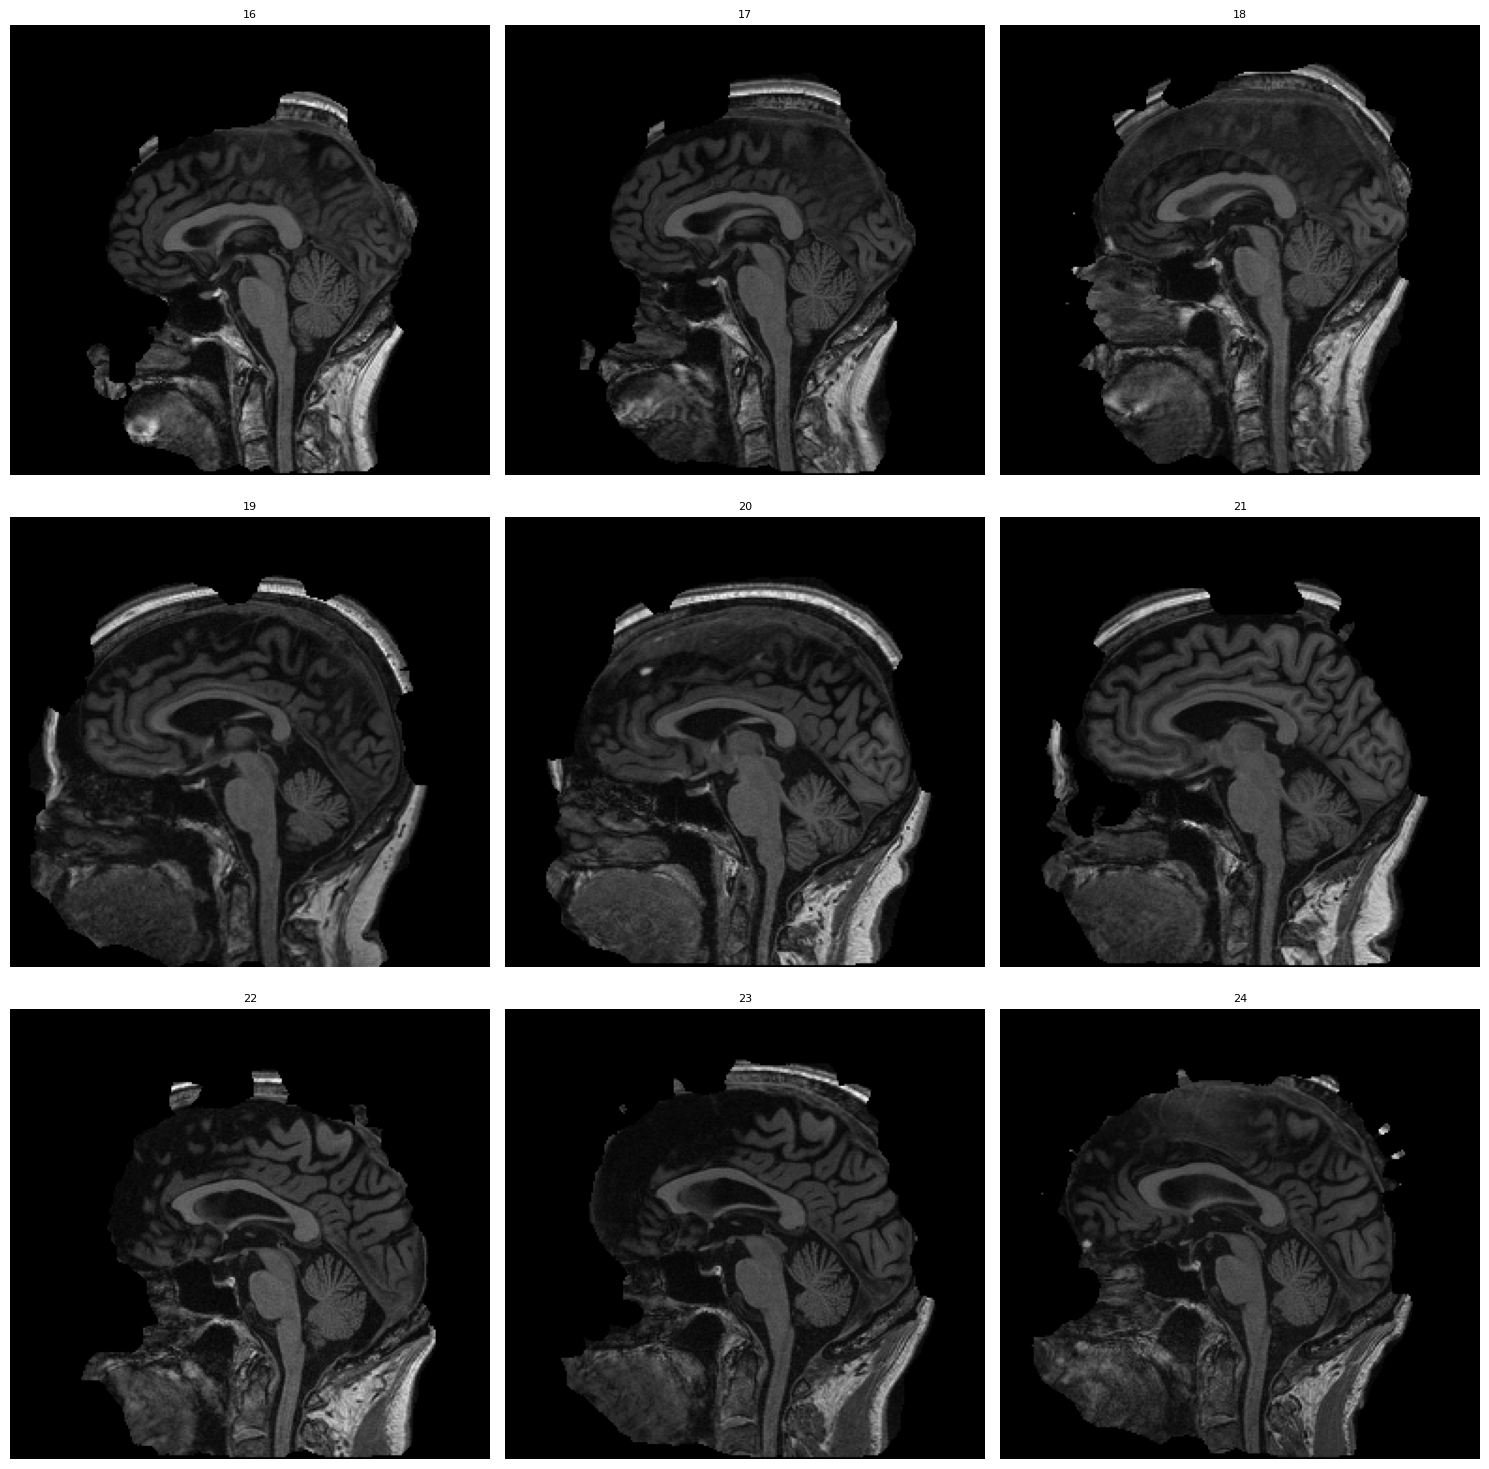

In [114]:
plot_middle_slices_in_range(
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\bids_sick_extracted\step3\MCI\240_256_160"
    , 0, 9, axis=2, endwith=".nii.gz")

### I know how to fix all of this using FSL, but its timeconsuming, and I am not going further down this rabbit hole, moving over to using synthstrip for brain cuts, from the first tests it looks extremely good..